# Voorspellen duur energie-neutraal huishouden

Eindopdracht data engineer opleiding [Bit-Academy](https://nlleertdoor.bit-academy.nl/). &copy; Paul Schouten 2022 

## Inleiding

Eind 2019 is mijn dak voorzien van zonnepanelen. Deze produceren op een zonnige dag in totaal tussen de 20 en 30kWh. Niet alle energie wordt op dat moment verbruikt door het huis. De overtollige energie stroomt terug het net in. Zonnepanelen zijn erg populair geworden, mede dankzij de subsidie erop. Voorheen werd het surplus aan energie weggestreept tegen de hoeveelheid afgenomen energie, de saldeerregeling. 

Echter, de saldeerregeling zal vanaf 2023 langzaam afgebouwd worden. Op een zonnige zomerdag zullen de panelen veel meer energie produceren dan wat er verbruikt kan worden. Op een sombere winterdag zal dit andersom zijn: er zal dan meer energie verbruikt dan wat er opgewekt zal worden. Een oplossing hiervoor zou het opslaan van energie kunnen zijn. Een lange periode aan energie opslaan is geen reële situatie: per jaar wordt ongeveer 3000kWh energie verbruikt. Dan zou er (geschat) 400kWh energie (ongeveer evenveel capaciteit als 7 [Tesla Model 3](https://en.wikipedia.org/wiki/Tesla_Model_3)'s op een rij, deze passen niet op de oprit...) opgeslagen moeten worden om door de drie donkerste maanden te komen. Een optie die wel mogelijk is, is het gebruik van een thuisaccu. Overdag wordt de accu opgeladen door de zonnepanelen. 's Avonds kan deze opgeslagen stroom weer gebruikt worden om het huis te voorzien. De consumentenversies hebben een capaciteit tussen de 4 en 10kWh. 

## Opdrachtomschrijving

Aangezien de opbrengst van zonnepanelen afhankelijk is van het weer, is bij mij de vraag ontstaan: kan de opbrengst voorspeld worden? De uitkomst hiervan bepaalt hoe lang er (met een accu van 7kWh) energie-neutraal overbrugd kan worden. De aanname hierbij is dat het verbruik van energie gemiddeld is per dag en dat een de accu als een ideale buffer werkt.

Deze vraag kan opgesplitst worden in de volgende onderdelen:
- Hoeveel energie is geproduceerd in het verleden?
- Wat was het weer in deze periode?
- Kunnen deze gegevens gecombineerd worden tot één dataset?
- Kan met deze dataset voorspeld worden wat de energieopbrengst gaan zijn?
- Hoe lang zal een (fictieve) accu het huis kunnen voorzien van energie?

## Gegevens verzamelen

Het opzoeken van de energieproductie is te vinden in `ophalen_solaredge.py`. In deze file wordt via de API van SolarEdge (leverancier van de inverter) de historische gegevens opgehaald en in een database file opgeslagen. Het opzoeken van het weer staat beschreven in `ophalen_weer.py`. De weersvoorspelling is te vinden in `ophalen_weersvoorspelling.py`. Zowel de historische weergegevens als de weersvoorspelling komen van het KNMI. Voor de historische gegevens is een [API](https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script) beschikbaar. De weersvoorspelling wordt via een iets creatievere manier opgehaald: de benodigde gegevens staan in de [expert pluim](https://www.knmi.nl/nederland-nu/weer/waarschuwingen-en-verwachtingen/weer-en-klimaatpluim). Op deze webpagina wordt op de achtergrond een aantal JSON files opgehaald. In het script worden deze JSONs direct benaderd. De dataset wordt gecombineerd in `build_dataset.py`. Voor het gemak `import`eert deze file de voorgaande drie files. De verdere analyse en voorspelling staan hierbeneden uitgewerkt.

## Dataset importeren

In onderstaand codeblok wordt de dataset ingelezen uit de SQLite3 database. 


In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Database inlezen
conn = sqlite3.connect("database.db")
dataset = pd.read_sql('SELECT * FROM dataset', conn)
conn.close()

# Voor de zekerheid NaN weglaten (mochten ze er zijn)
dataset.dropna(axis=0, inplace=True)

# Dataset laten zien
dataset.tail()


,Time,temperatuur,duur_neerslag,bewolking,solar_altitude,solar_azimuth,energy
22001,2022-03-07 18:00:00+00:00,3.0,0.0,0.0,-6.575459,268.612071,0.0
22002,2022-03-07 19:00:00+00:00,2.9,0.0,0.0,-15.928821,280.476603,0.0
22003,2022-03-07 20:00:00+00:00,1.3,0.0,0.0,-24.911127,293.207256,0.0
22004,2022-03-07 21:00:00+00:00,1.9,0.0,0.0,-33.012131,307.555923,0.0
22005,2022-03-07 22:00:00+00:00,1.3,0.0,0.0,-39.556099,324.230966,0.0


Met Seaborn worden deze gegevens geplot. Seaborn heeft hiervoor `pairplot`, of voor meer geavanceerde opties `PairGrid`. In deze plot wordt iedere parameter ten opzichte van alle andere parameters geplot. In de onderstaande grafiek is ervoor gekozen om op de diagonaal de verdeling van de parameter zelf te tekenen. Onder de diagonaal staat een _scatterplot_, boven de diagonaal een _kdeplot_. KDE staat in dit geval voor _kernel density estimation_. Deze is het gemakkelijkst te omschrijven als een twee dimensionaal histogram, waar de diepte van de kleur het aantal waarnemingen weergeeft. 

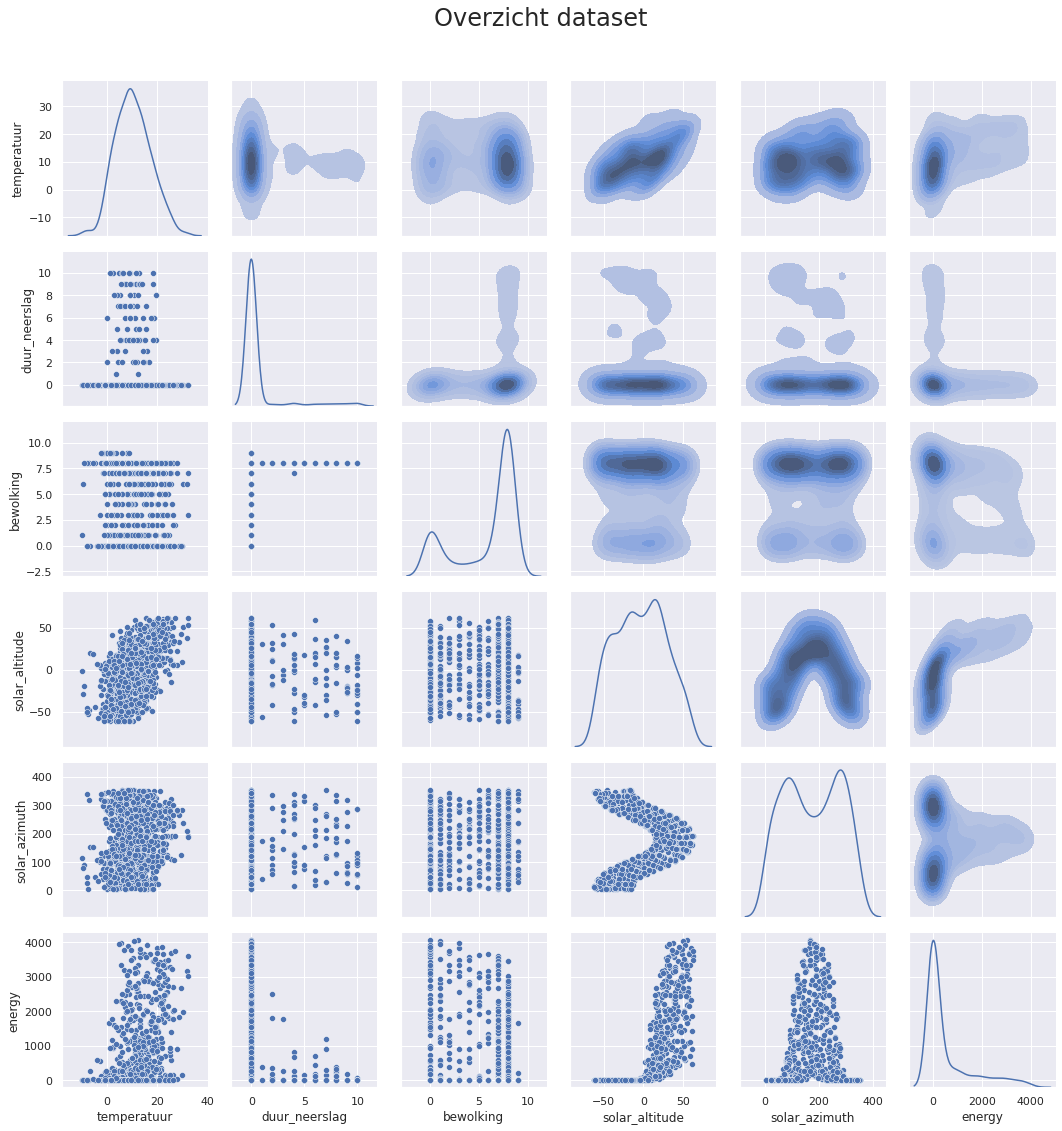

In [2]:
# Pair plot tekenen, in een apart code blok, 
# Met .sample(n) wordt het genereren van de grafiek versneld.
sns.set_theme()

g = sns.PairGrid(dataset.sample(1000), diag_sharey=False);
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot)
g.fig.suptitle('Overzicht dataset', y=1.05, fontsize=24)

plt.show()


### Beschrijving data

Een overduidelijk (lineair) verband is niet zichtbaar. De temperatuur ziet er redelijk normaal verdeeld uit. De bewolking laat een bimodale verdeling zien, is er óf geen bewolking óf veel. De stand van de zon geeft een redelijk mooi beeld: hoe hoger de zon staat, hoe meer energie geproduceerd wordt. In de verdraaiing (azimuth) van de zon is te zien dat wanneer de zon in het zuiden staat de energieproductie het hoogst is. Dit is correct, het dakdeel met de zonnepanelen staan op het zuiden gericht. De gegenereerde energie laat een grote bult zien vlak bij de nul. Dit is ook wel te verwachten: er wordt maar op een paar momenten een piekvermogen geleverd. Tijdens de nacht wordt er helemaal geen energie geproduceerd.

Ondanks de grote spreiding op de getallen ziet het er naar uit dat wanneer het warmer is dat er meer energie geproduceerd wordt. Dit is logisch: in de zomer is is het warmer, omdat er meer zon is. Hierdoor wordt er dus ook meer energie geleverd. Een tegenvaller is de bewolking: op het eerste gezicht wordt er maar een beetje minder energie geproduceerd bij hogere bewolkingsgetallen. 

Onderstaand is een 3d grafiek getekend. Op de x- en y-as staat de positie van de zon. De z-as geeft de hoeveelheid geproduceerde energie weer. Met de kleur van de bolletjes wordt de hoeveelheid bewolking aangegeven; een hogere helderheid geeft minder bewolking aan.

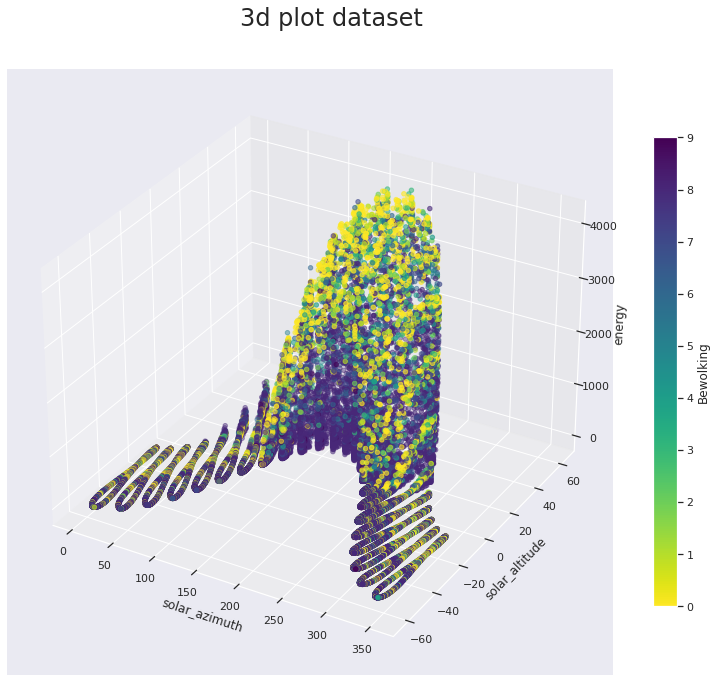

In [3]:
# 3d grafiek tekenen
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# x en y: stand zon
# z: energie
# c: bewolking
x = dataset["solar_azimuth"]
y = dataset["solar_altitude"]
z = dataset["energy"]
c = dataset["bewolking"]

# Grafiek zelf tekenen
p = ax.scatter(x, y, z, c=c, marker='o', cmap=plt.cm.viridis_r)
ax.set_xlabel('solar_azimuth')
ax.set_ylabel('solar_altitude')
ax.set_zlabel('energy')

# Colormap toevoegen
plt.rcParams['axes.grid'] = False
cbar = fig.colorbar(p, fraction=0.035, pad=0.06);
cbar.set_label("Bewolking")

# Titel
fig.suptitle('3d plot dataset', y=0.925, fontsize=24)
plt.show()


Ook in deze plot is te zien dat door de dag heen bij een hogere stand van de zon (solar_altitude) èn minder bewolking (gele bolletjes) er meer energie geproduceerd wordt.

## Modelleren

Om te voorspellen hoeveel energie er opgewekt gaat worden, wordt eerst naar het verleden gekeken. In de gecombineerde dataset staat zowel de energieopbrengst als de weeromstandigheden. Om te kijken of de opbrengst voorspeld kan worden, is er regressie toegepast via een machine learn model. In dit hoofdstuk worden twee modellen getest: kNN en XGBoost.

### kNN

Het eerste model wat gebruikt is kNN. Dit staat voor (het aantal _k_) **k N**earest **N**eighbours. Normaal gesproken wordt dit model vooral gebruikt bij het classificeren van items, maar deze is ook te gebruiken voor regressie. Het verschil tussen classificeren en regressie is in deze zin het verschil tussen bijvoorbeeld het voorspellen van "het is half bewolkt" (in een vaste omschrijving) en het bepalen van de geproduceerde hoeveelheid energie (dit is een continue schaal).

In [4]:
# Eerste run met kNN model
# - Data splitsen en inschalen
# - Data fitten, resultaat laten zien
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Opsplitsen dataset
X = dataset[["temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Omzetten data naar standaardverdeling, kNN schaalt deze niet zelf in
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# kNN model opstarten, met standaard parameters
knn_model = KNeighborsRegressor()

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
print('Train set:')
score = knn_model.score(X_train, y_train)   # score is r²
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_train = knn_model.predict(X_train)
mse = mean_squared_error(y_train, predicted_train)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

# Matchen aan test set
print('\nTest set:')
score = knn_model.score(X_test, y_test)
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_test = knn_model.predict(X_test)
mse = mean_squared_error(y_test, predicted_test)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

Train set:
r²: 0.90
RMSE: 308

Test set:
r²: 0.84
RMSE: 393


Hoe nauwkeurig een model de uitkomst voorspelt is uit te drukken met de [determinatiecoëfficiënt](https://en.wikipedia.org/wiki/Coefficient_of_determination). Dit getal ligt tussen de 0 (totaal geen verband met elkaar) tot 1 (perfect verband). Een r² van 0.90 voor de trainingsset en 0.84 voor de testset is redelijk goed te noemen. Met meer statistiek is een uitspraak met hogere betrouwbaarheid te bepalen, dit wordt hier achterwege gelaten. Ook wordt de [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error) uitgerekend, dit is een maat voor hoever de datapunten van de regressielijn af liggen. Met beide parameters kan vergeleken worden of een aanpassing in het model een verbetering of juist een verslechtering oplevert. Gemiddeld wordt er een fout van circa 300-400 Wh gemaakt. 

#### Optimaliseren van parameters

Met `GridSearchCV` van `sklearn` kan bepaald worden welke parameters optimaal zijn voor het voorspellen van deze dataset. In principe is deze module te vergelijken met een _loop_ waar de opgegeven parameters uitgeprobeerd worden. De beste _fit_ wordt als resultaat teruggeven.

In [5]:
# Bepalen welke parameters beste zijn voor de voorspelling
from sklearn.model_selection import GridSearchCV

# Welke parameters te optimaliseren
parameters = { 
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# Zoeken naar beste parameters (duurt ff)
# Met n_jobs=-1 worden alle processors (threads) gebruikt,
# TLDR: Laptop doet vrrrr
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_

print(f'Best parameters: {best_params}')

# Herhalen kNN model met optimale instellingen
# kNN model opstarten, met uitkomst gridsearch
knn_model = KNeighborsRegressor(
                n_neighbors=best_params["n_neighbors"],
                weights=best_params["weights"],
                p=best_params["p"])

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
print('\nTrain set:')
score = knn_model.score(X_train, y_train)   # score is r²
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_train = knn_model.predict(X_train)
mse = mean_squared_error(y_train, predicted_train)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

# Matchen aan test set
print('\nTest set:')
score = knn_model.score(X_test, y_test)
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_test = knn_model.predict(X_test)
mse = mean_squared_error(y_test, predicted_test)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')


Best parameters: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}

Train set:
r²: 1.00
RMSE: 8

Test set:
r²: 0.86
RMSE: 372


Hierboven is te zien dat GridSearch een uitstekend resultaat oplevert: een r² van 1.00 en de daarbij behorende lage RMSE. Aan de test set is te zien dat dit erg optimistisch is: hier gaat de r² maar een klein beetje omhoog: van 0.84 naar 0.86. De RMSE daalt ongeveer 5\%.

#### Nauwkeurigheid model

De nauwkeurigheid van de test-set voorspelling is weergegeven in de onderstaande grafiek: er zit nogal wat spreiding op de voorspelling. In het ideale geval zullen alle punten op de diagonaal liggen. Beneden ongeveer 1500 Wh is er een overschatting van de energieproductie, erboven lijkt het een onderschatting. Dit kan aan het gekozen model liggen, maar ook aan de verdeling van de hoeveelheid data. Er is veel meer data in het lage gebied ten opzichte van de hoeveelheid gegevens in het hoge gebied.

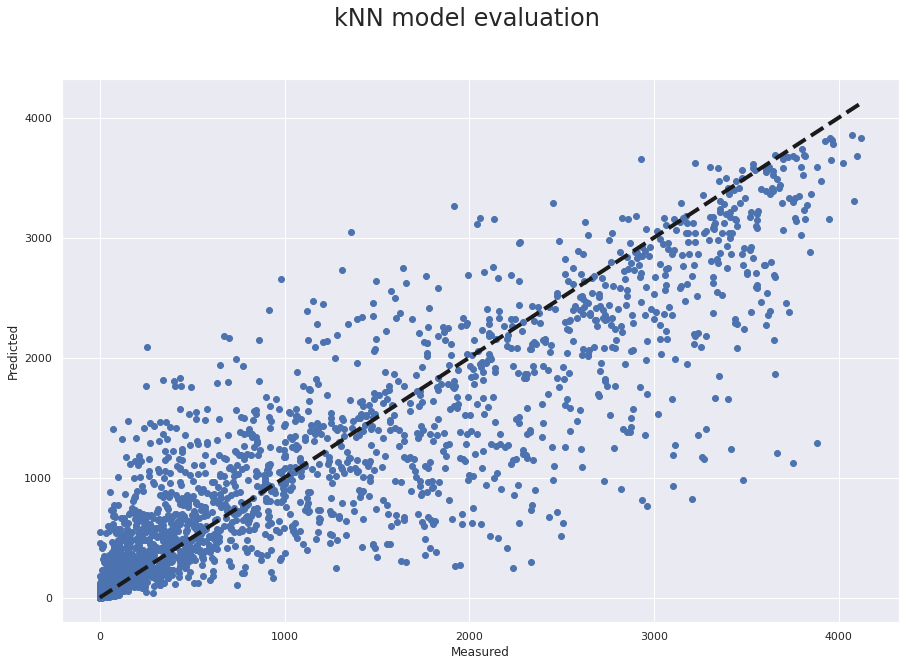

In [6]:
# Grafiek tekenen, evaluatie voorspelling
sns.set_theme()

fig, ax = plt.subplots(1, figsize=(15,10))
ax.scatter(y_test, predicted_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")

fig.suptitle("kNN model evaluation", fontsize=24)
plt.show()


Ondanks de hoge r² is er flink wat spreiding op de restultaten. Dit is een reden om de bruikbaarheid van kNN voor de voorspelling van de energieproductie niet te gebruiken. In het volgende hoofdstuk wordt een ander machine-learn model gebruikt.

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is een machine learn systeem gebaseerd op decision trees. Bij dit type modellen worden de gegevens gesplitst. Iedere split zorgt ervoor dat de kwaliteit van de gesplitste data toeneemt, dus dat het steeds duidelijker wordt in welke catagorie de gegevens thuis horen. XGBoost doet dit op een slimme, maar vooral snelle manier volgens de documentatie. In onderstaand codeblok worden de geoptimaliseerde parameters voor het model gebruikt.


In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Opsplitsen datum/tijd naar jaar-maand-dag-uur
dataset['timestamp'] = pd.to_datetime(dataset["Time"])
dataset.set_index("timestamp", inplace=True)

dataset['dayofyear'] = dataset.index.dayofyear
dataset['year'] = dataset.index.year
dataset['quarter'] = dataset.index.quarter
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.day
dataset['hour'] = dataset.index.hour

# Opsplitsen dataset
X = dataset[["dayofyear", "year", "quarter", "month", "day", "hour", "temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

# split into train and test set
# Note: this is on a NON standardized dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Parameters for training model
params = {'objective':'reg:squarederror',
         'eta': 0.05,
         'gamma': 1,
         'max_depth': 10,
         'lambda': 5,
         'alpha': 0,
         'min_child_weight': 1}

# Train model with parameters and
# look at 'rmse' (minimize)
# maximum 10000 rounds
# stop when result does not improve in 3 subsequent iterations
trained_model = xgb.train(params=params,
                          dtrain=dmatrix,
                          evals=[(dmatrix, 'rmse')],
                          verbose_eval=1000,
                          num_boost_round=10000,
                          early_stopping_rounds=3)

print(f'Num rounds: {trained_model.num_boosted_rounds()}')

# Check prediction for train set
print('\nTrain set:')
pred_train = trained_model.predict(xgb.DMatrix(data=X_train))

score = r2_score(y_train, pred_train)
print(f'r²: {score:.2f}')
print(f'RMSE train set: {sqrt(mean_squared_error(y_train, pred_train)):.2f}')

# Check prediction for test set
print('\nTest set:')
pred_test = trained_model.predict(xgb.DMatrix(data=X_test))

score = r2_score(y_test, pred_test)
print(f'r²: {score:.2f}')
print(f'RMSE test: {sqrt(mean_squared_error(y_test, pred_test)):.2f}') 


[0]	rmse-rmse:1057.97302


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1000]	rmse-rmse:56.65597
[2000]	rmse-rmse:21.80414
[3000]	rmse-rmse:8.08258
[4000]	rmse-rmse:3.56152
[4493]	rmse-rmse:2.52238
Num rounds: 4494

Train set:
r²: 1.00
RMSE train set: 2.52

Test set:


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


r²: 0.88
RMSE test: 329.34


Met de standaard parameters van XGBoost worden vergelijkbare resultaten behaald bij de test-set als met een geoptimaliseerd kNN model. 

#### Optimaliseren XGBoost

Ook bij XGBoost kunnen de parameters geoptimaliseerd worden. Op de dataset worden verschillende modelparameters getest. Dit zijn de volgende parameters in de documentatie van XGBoost:

- `eta` aka learning_rate: kleinere stappen voorkomt overfitting, geteste range: 0.05-1, default: 0.3
- `gamma` aks min_split_loss: minimum wat een split aan verbetering moet geven, geteste range: 0-5, default: 0
- `max_depth`: maximum diepte van de tree; te groot is risico overfitting, geteste range 6-10, default: 6
- `lambda`: L2 parameter. Verhogen levert een meer conservatief model op
- `alpha`: L1 parameter. Verhogen levert een meer conservatief model op
- `min_child_weight`: Minimale som voor iedere `child`. Met deze parameter wordt het verder splitsen van de `tree` eerder gestopt.

De resultaten worden verzameld in een DataFrame, om ze te kunnen vergelijken.

In [8]:
from itertools import product
import time

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X, label=y) 

# Functie die model met parameters x[...] uitvoert.
# met CrossValidation wordt het model getraind en
# geëvalueerd. Het resultaat wordt weer teruggegeven
def test_parameters(x):
    # Parameters for training model
    params = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'eta': x[0],
              'gamma': x[1],
              'max_depth': int(x[2]),
              'lambda': x[3],
              'alpha': x[4],
              'min_child_weight': x[5],
              'tree_method': 'auto'}
    
    # Voortgang laten zien
    #print(f'Testing: {params}') 
    print('.', end='')
    
    # Cross validation uitvoeren,
    # Het model splitst de data in _nfold_ delen op
    # en traint en valideert over ieder stuk
    xgb_cv = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=5, 
                    metrics = 'rmse',
                    num_boost_round=10000,
                    early_stopping_rounds=3,
                    #verbose_eval=500,
                   )
    
    # Return de laatste regel
    return xgb_cv[-1:].values[0]

# Maak een search grid, itertools.product van welke waarden voor welke items
# - eta aka learning_rate: kleinere stappen voorkomt overfitting, range: 0-1 (0.3)
# - gamma aks min_split_loss: minimum wat een split aan verbetering moet geven, range: 0--> inf (0)
# - max_depth: maximum diepte van de tree te groot is risico overfitting, range 0--> inf (6)
# Dit zijn de eerste 3 parameters van xgboost:
# https://xgboost.readthedocs.io/en/stable/parameter.html

# 1e run: beste fit met gamma = 0
# grid = pd.DataFrame(product([0.1, 0.3, 0.5], [0, 1, 10], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])
# 2e run: gamma=0, meer stapjes in eta
# grid = pd.DataFrame(product([0.05, 0.1, 0.15], [0, 1], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])
# 3e run: max_depth = 6, lagere eta
# grid = pd.DataFrame(product([0.05, 0.1, 0.3, 1.0], [0, 1, 2, 5], [6, 10], [1, 5], [0, 3], [1, 5]), 
#                     columns=['eta', 'gamma', 'max_depth', 'lambda', 'alpha', 'min_child_weight'])
# 4e run: verschillende parameters laten lopen, beperktere set ivm processing time
grid = pd.DataFrame(product([0.05, 0.3], [0, 1], [10], [1, 5], [0, 3], [1, 5]), 
                    columns=['eta', 'gamma', 'max_depth', 'lambda', 'alpha', 'min_child_weight'])

# Voor iedere regel in _grid_ (set aan parameters) de _fit_ functie aanroepen
print('Parameters testen', end='')
time_start = time.time()
grid[['train-mean','train-std', 'test-mean','test-std']] = grid.apply(test_parameters, axis=1, result_type='expand')
time_done = time.time()

print(f"\nBeste test: \n{grid[grid['test-mean'] == grid['test-mean'].min()]}")
print(f"\nBeste train: \n{grid[grid['train-mean'] == grid['train-mean'].min()]}")

print(f'Tijd nodig: {(time_done - time_start):.1f} sec')

# resultaten laten zien
grid.sort_values(by="test-mean")


Parameters testen.

/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


...............................
Beste test: 
    eta  gamma  max_depth  lambda  alpha  min_child_weight  train-mean  \
7  0.05      0         10       5      3                 5  209.372858   

   train-std  test-mean  test-std  
7   3.745702  323.12085  9.603226  

Beste train: 
    eta  gamma  max_depth  lambda  alpha  min_child_weight  train-mean  \
2  0.05      0         10       1      3                 1  162.347516   

   train-std   test-mean  test-std  
2   4.031638  327.992224  9.615455  
Tijd nodig: 254.1 sec


,eta,gamma,max_depth,lambda,alpha,min_child_weight,train-mean,train-std,test-mean,test-std
7,0.05,0,10,5,3,5,209.372858,3.745702,323.120850,9.603226
15,0.05,1,10,5,3,5,209.425949,3.635207,323.164435,9.528605
5,0.05,0,10,5,0,5,208.534888,3.218111,323.445294,9.223868
4,0.05,0,10,5,0,1,189.847141,2.963482,323.755200,9.715912
12,0.05,1,10,5,0,1,189.045465,3.589422,323.975073,9.866455
13,0.05,1,10,5,0,5,208.081149,2.697923,324.007025,9.510035
6,0.05,0,10,5,3,1,194.788388,2.732226,324.351507,8.909491
14,0.05,1,10,5,3,1,191.569574,1.864326,324.457330,8.847812
9,0.05,1,10,1,0,5,187.987659,2.522086,327.121448,9.084432
3,0.05,0,10,1,3,5,187.505997,2.937070,327.230432,8.094647


Waar bij de eerste run, met de hele train dataset, een hele goede fit wordt behaald, is de fit die behaald wordt met cross-validation een stuk minder. Dit was ook al zichtbaar bij het vergelijken van de train met de test data set. Het variëren van de parameters levert maar een kleine verbetering op. Er is voor gekozen om met de beste parameters verder te gaan. Net zoals bij het kNN model wordt de voorspelde waarde vergeleken met de gemeten waarde.

#### Nauwkeurigheid model

De nauwkeurigheid van de test-set voorspelling is weergegeven in de onderstaande grafiek: er zit nogal wat spreiding op de voorspelling. In het ideale geval zullen alle punten op de diagonaal liggen. Beneden ongeveer 1500 Wh is er een overschatting van de energieproductie, erboven lijkt het een onderschatting. Dit kan aan het gekozen model liggen, maar ook aan de verdeling van de hoeveelheid data. Er is veel meer data in het lage gebied ten opzichte van de hoeveelheid gegevens in het hoge gebied.

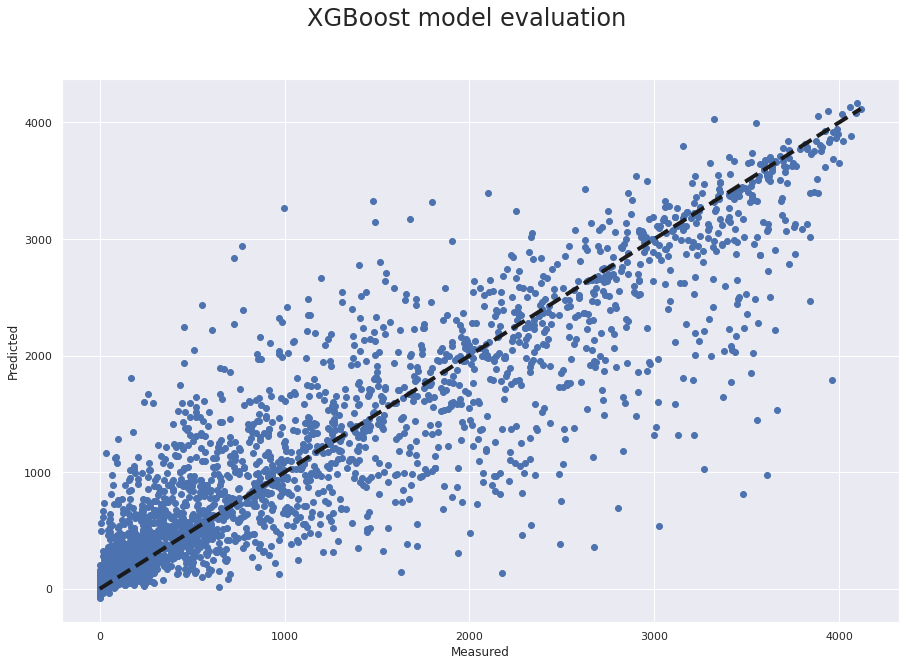

In [9]:
# Grafiek tekenen, evaluatie voorspelling
sns.set_theme()

fig, ax = plt.subplots(1, figsize=(15,10))
ax.scatter(y_test, pred_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")

fig.suptitle("XGBoost model evaluation", fontsize=24)
plt.show()


Het XGBoost model kan ook laten zien welke parameters het meest belangrijk zijn in de voorspelling. 

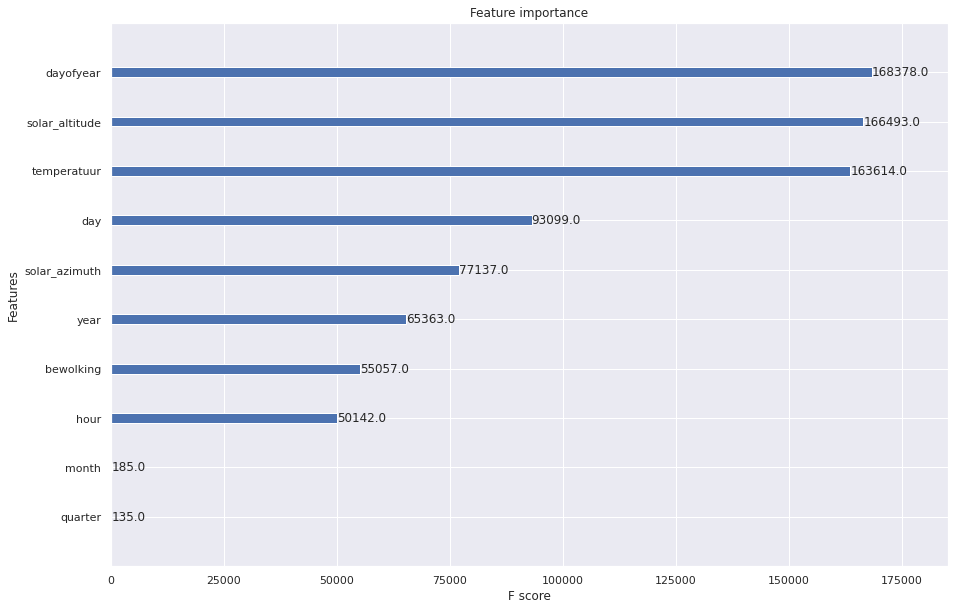

In [10]:
# Laten zien welke parameters het belangrijkste (meest voorkomende) in het model zijn
fig, ax = plt.subplots(1, figsize=(15,10))
xgb.plot_importance(trained_model, ax=ax)
plt.show()

Uit deze grafiek blijkt dat (redelijk verrassend) de temperatuur een grote voorspeller is voor de energieopbrengst. Daarna komen de dag van het jaar en de positie van de zon. 

## Batterij duur

Om te bepalen hoe lang de batterij mee gaat, wordt het principe `in - uit + productie = accumulatie` toegepast, vanuit het oogpunt van de batterij en de zonnepanelen. De hoeveelheid `in` is dan nul, aangenomen wordt dat de batterij niet opgeladen wordt via het net. Het energieverbruik is `uit` en wordt als constant door de dag heen beschouwd: 3500 kWh/jaar / 365 dagen/jaar / 24 uren/dag = 0.4 kWh per uur. De `productie` is de energie van de zonnepanelen. Als laatste blijft dan de `accumulatie` over, het opladen (of als deze negatief is het ontladen) van de batterij. Er wordt voor de voorspelling gestart met een volle batterij. Het XGBoost model wordt gebruikt in de voorspelling, omdat deze een meer reëel beeld geeft van de voorspelde energieproductie ten opzichte van het kNN model.


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


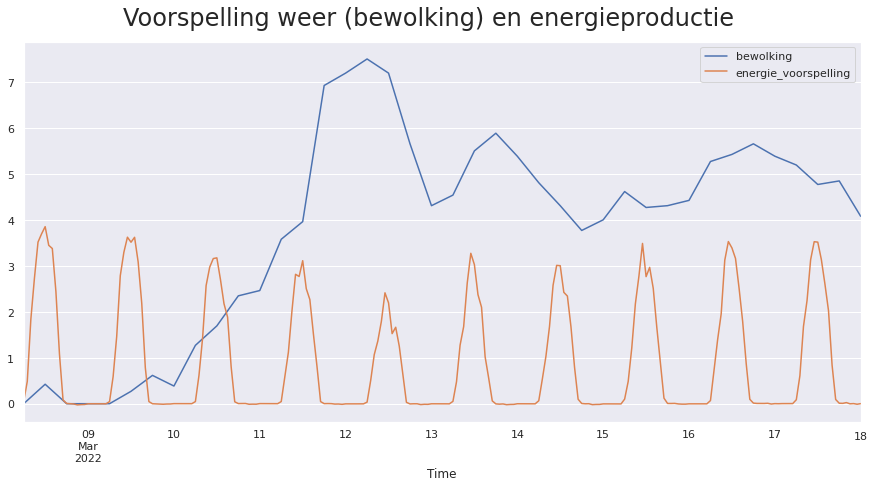

In [11]:
import pysolar

# Database inlezen
conn = sqlite3.connect("database.db")
voorspelling = pd.read_sql('SELECT * FROM knmi_forecast', conn)
conn.close()

# Tijd omzetten naar DateTime
# Toch jammer dat dit niet standaard gebeurd... (SQLite3 beperking als ik het goed heb...)
voorspelling["Time"] = pd.to_datetime(voorspelling["Tijdstip"])
voorspelling.drop(columns=["Tijdstip"], inplace=True)
voorspelling.set_index("Time", inplace=True)

voorspelling['dayofyear'] = voorspelling.index.dayofyear
voorspelling['year'] = voorspelling.index.year
voorspelling['quarter'] = voorspelling.index.quarter
voorspelling['month'] = voorspelling.index.month
voorspelling['day'] = voorspelling.index.day
voorspelling['hour'] = voorspelling.index.hour


# KNMI geeft per 6 uur voorspelling, interpoleren naar per uur
voorspelling = voorspelling.resample("1H").interpolate(method="linear")

# Info stand zon toevoegen
voorspelling["solar_altitude"] = pysolar.solar.get_altitude_fast(51.2, 6, voorspelling.index)
voorspelling["solar_azimuth"] = pysolar.solar.get_azimuth_fast(51.2, 6, voorspelling.index)

# Voorspelling energie berekenen:
# - Selecteren
# - Transformeren (standardscaler)
# - Prognosticeren (rijmt lekker)
X = voorspelling[['dayofyear', 'year', 'quarter', 'month', 'day', 'hour', "temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]

# Energie per kWh, niet per Wh
voorspelling["energie_voorspelling"] = trained_model.predict(xgb.DMatrix(data=X)) / 1000

# Verwachting voor de komende dagen laten zien
sns.set_theme()

fig, ax = plt.subplots(figsize=(15, 7))
g = voorspelling[["bewolking", "energie_voorspelling"]].plot(ax=ax)
fig.suptitle('Voorspelling weer (bewolking) en energieproductie', y=.95, fontsize=24)
plt.show()

In de plot is te zien dat het model op het eerste gezicht een redelijke voorspelling geeft. Er zijn geen negatieve getallen in de voorspelling en het maximum vermogen van de zonnepanelen (4.5 kWp) wordt niet overschreden. Bij meer bewolking is een lagere opbrengst te zien. In de onderstaande tabel staat het totaal per dag weergegeven:


In [12]:
# Opgetelde voorspelling per dag laten zien
voorspelling["energie_voorspelling"].resample("1D").sum().astype('float').round(1).to_frame()

,energie_voorspelling
Time,
2022-03-08,26.5
2022-03-09,25.0
2022-03-10,21.5
2022-03-11,19.6
2022-03-12,14.4
2022-03-13,18.4
2022-03-14,19.2
2022-03-15,21.1
2022-03-16,22.6


Uit bovenstaande tabel is op te maken dat de voorspelde energieproductie aan de hoge kant is. Diverse simulaties (in Februari 2022) geven een totaal van rond 20 kWh aan. Deze  wordt normaal voor een goede zomerdag verwacht. Ondanks dit wordt het niveau van de batterij in de tijd hierbeneden verder uitgewerkt.

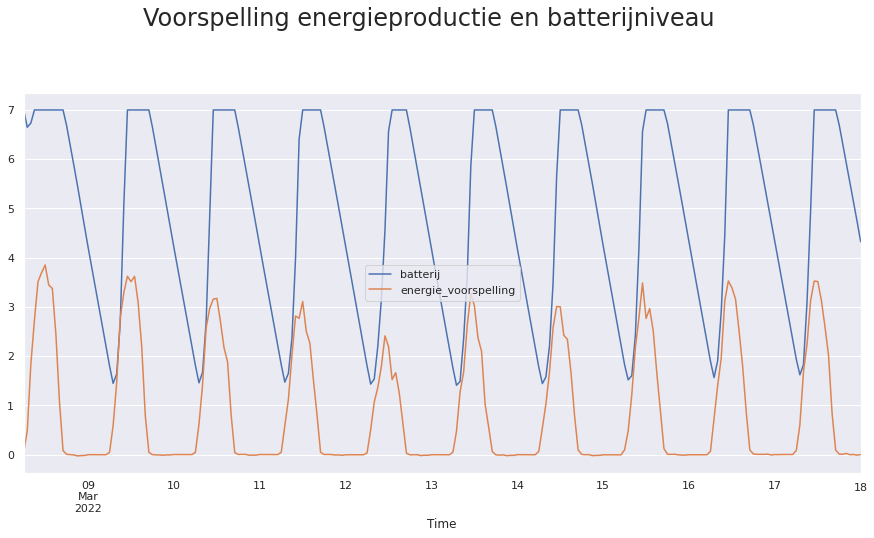

De batterij gaat de gehele periode mee


In [13]:
import math
# Nieuwe kolom aanmaken voor het niveau van de batterij,
# beginnen met een volle (7 kWh)
voorspelling["batterij"] = 0
bat_kolom = voorspelling.columns.get_loc("batterij")
voorspelling.iat[0, bat_kolom] = 7

energie_kolom = voorspelling.columns.get_loc("energie_voorspelling")

# Loop over alle rijen van het DataFrame. Op deze manier is de 
# vorige rij gemakkelijk te benaderen. Daarnaast kan het min/max
# niveau van de batterij gevolgd worden. _batterij_leeg_ wordt als
# "flag" gebruikt, om aan te geven dat de batterij leeg is.
batterij_leeg = False
for i in range(1, len(voorspelling)):
    # Opzoeken getallen om mee te rekenen
    productie = voorspelling.iloc[i-1, energie_kolom]
    accumulatie = 0 - 0.4 + productie
    bat_vorig = voorspelling.iloc[i-1, bat_kolom]
    
    # Nieuw batterijniveau berekenen, deze is:
    # - maximaal (min in deze functie) 7 kWh
    # - minimaal (max in deze functie) 0 kWh
    bat_huidig = max(min(7, bat_vorig + accumulatie), 0)
    if bat_huidig == 0 or batterij_leeg:
        batterij_leeg = True
        bat_huidig = math.nan
    
    voorspelling.iat[i, bat_kolom] = bat_huidig

# Grafiek tekenen
fig, ax = plt.subplots(figsize=(15, 7))
voorspelling[["batterij", "energie_voorspelling"]].plot(ax=ax)
fig.suptitle('Voorspelling energieproductie en batterijniveau', y=1.05, fontsize=24)
plt.show()

if batterij_leeg: 
    print(f'De batterij is leeg op: {max(voorspelling.dropna().index)}')
else:
    print('De batterij gaat de gehele periode mee')

Met diverse runs in februari lijkt het zelfs mogelijk om geheel autonoom te functioneren. Ook is te zien dat de batterij snel vol zit. Dat er zo lang zonder externe stroom gefunctioneerd kan worden is echter onwaarschijnlijk.

## Model evaluatie

Om het model te evalueren is onderstaande grafiek gemaakt. Deze laat in de tijd zien welke energie productie er voorspeld is versus de actuele opbrengst van de zonnepanelen. Bij herhaalde simulaties zal er ook een onzekerheid getekend worden. In verband met het verversen van de weersvoorspelling door het KNMI wordt er maar één keer per dag de simulatie opgeslagen in de database.

Ophalen evaluation OK
Getting solaredge data from 2022-02-09 06:00:00


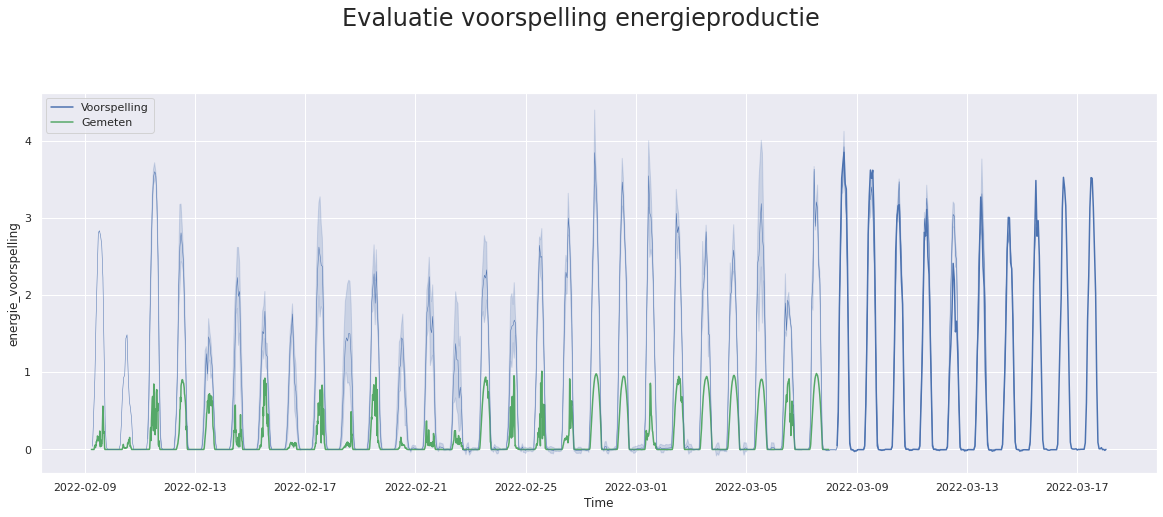

Voorspelling voor vandaag opslaan


In [14]:
# 1. Vanaf wanneer tekenen?
# Model evaluatie tekenen vanaf eerste run,
# Dit is de eerste datum in "evaluation" of anders
# de eerste datum van "voorspelling"
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# Datum opvragen in try...             except... 
#                   (tabel bestaat)... (eerste run)...
try:
    sql = 'SELECT * FROM knn_evaluation'
    previous_runs = pd.read_sql(sql, conn)
    previous_runs["Time"] = pd.to_datetime(previous_runs["Time"])
    first_date = previous_runs["Time"].min()
    print("Ophalen evaluation OK")
    
except (sqlite3.Error, pd.io.sql.DatabaseError) as e:
    print(f'Foutmelding database: {e}')
    first_date = voorspelling.index.min()
    previous_runs = None
    
print(f'Getting solaredge data from {first_date}')


# 2. Data ophalen uit database solaredge
sql = f'SELECT * FROM solaredge_history WHERE DATETIME(tijdstip) >= DATETIME("{first_date}")'
solaredge = pd.read_sql(sql, conn)

# Tijd omzetten naar datetime
solaredge["Time"] = pd.to_datetime(solaredge["tijdstip"])
solaredge.set_index("Time", inplace=True)
solaredge.drop("tijdstip", axis=1, inplace=True)

# Tijdzone info toevoegen, SolarEdge is in de "local" time
solaredge = solaredge.tz_localize("Europe/Amsterdam", ambiguous="NaT", nonexistent="NaT")

# Energie van Wh naar kWh
solaredge["energy"] = solaredge["energy"] / 1000.0

# Grafiek opbouwen
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(data=voorspelling, x="Time", y="energie_voorspelling", color='b', ax=ax)
sns.lineplot(data=solaredge, x="Time", y="energy", color='g', ax=ax)
if previous_runs is not None: 
    sns.lineplot(data=previous_runs, x="Time", y="energie_voorspelling", color='b', linewidth=0.5, ax=ax)
plt.legend(labels=["Voorspelling", "Gemeten"], loc="upper left")
fig.suptitle('Evaluatie voorspelling energieproductie', y=1.05, fontsize=24)
plt.show()

# 3. Huidige voorspelling opslaan (alleen voor vandaag)
# Tabel aanmaken indien nog niet aanwezig
sql = """CREATE TABLE IF NOT EXISTS knn_evaluation_days ( 
            datum DATETIME PRIMARY KEY NOT NULL );
      """
conn.execute(sql)

# Datum van vandaag ophalen uit tabel
sql = f"SELECT datum FROM knn_evaluation_days WHERE datum = DATE('now')"
cursor.execute(sql)
result = cursor.fetchall()

if len(result) == 0:
    # Day not found, save voorspelling
    print("Voorspelling voor vandaag opslaan")
    exporteren = voorspelling[["temperatuur", "neerslag", "bewolking", "solar_altitude", "solar_azimuth", "energie_voorspelling", "batterij"]]
    exporteren.to_sql("knn_evaluation", conn, if_exists="append")
    
    sql = f"INSERT INTO knn_evaluation_days VALUES ( DATE('now') )"
    cursor.execute(sql)
else:
    print("Voorspelling voor vandaag is al opgeslagen")
    
conn.commit()
conn.close()

## Evaluatie en conclusie

In deze eindopdracht is een dataset zelf opgebouwd, beschreven en grafisch weergegeven. De energieopbrengst van de zonnepanelen is gemodelleerd met een kNN model en met XGBoost. Van beide modellen zijn de parameters geoptimaliseerd. De resultaten van de modellen zijn beoordeeld aan de hand van r² en RMSE. Het laatste model is gebruikt om samen met de weersverwachting te voorspellen hoe lang een fictieve accu mee zal gaan. 

De in de inleiding besproken deelvragen kunnen nu beantwoord worden:

- Hoeveel energie is geproduceerd in het verleden? &rarr; Dit is opgezocht middels de API van SolarEdge.
- Wat was het weer in deze periode? &rarr; Dit is opgezocht middels de API van het KNMI.
- Kunnen deze gegevens gecombineerd worden tot één dataset? &rarr; Ja, met _merging_, _resampling_ en het aanpassen van de _timezone_.
- Kan met deze dataset voorspeld worden wat de energieopbrengst gaan zijn? &rarr; Ja, dat is mogelijk, met een beperkte betrouwbaarheid.
- Hoe lang zal dan een (fictieve) accu meegaan, is het mogelijk om een langere periode energie-neutraal te overbruggen? &rarr; Afhankelijk van de opbrengst van de zonnepanelen kan er 1 tot 10 dagen energie-neutraal overbrugd worden. Hierbij wordt er wel aangenomen dat de accu ook in de piekbelasting kan voldoen. In het rekenmodel is uitgegaan van een gemiddeld energieverbruik.


## Aanbeveling verder onderzoek

De nauwkeurigheid van de voorspelling kan beter. Er is een relatieve grote spreiding te zien op de voorspelde energieproductie. Deze zou verbeterd kunnen worden door:

- Andere, meer significante, parameters op te zoeken. In de dataset van de historische gegevens van het KNMI staat ook bijvoorbeeld de globale straling _Q_. Als deze ook voor de weersvoorspelling uitgerekend kan worden, dan kan beoordeeld worden of deze parameter het model verbeterd.
- De weersvoorspelling wordt per 6 uur uitgerekend. Op dit moment wordt deze _geresampled_ naar 1 uur intervallen. Een optie ter verbetering is om de energieproductie naar deze frequentie te aggregeren.
- De manier waarop de bewolking in de historie staat versus de verwachting is anders. Een validatie op het berekenen van de bewolkingsscore kan bevestigen dat deze correct uitgevoerd is, of verder verbeterd kan worden.